# Leer desde HF

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import pandas as pd

La primera vez que descargas el dataset tarda 4 minutos

https://huggingface.co/datasets/gauss314/options-IV-SP500

In [ ]:
%%time
id = "gauss314/options-IV-SP500"
data_iv = load_dataset(id)
data = pd.DataFrame(data_iv['train'][:])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

CPU times: user 1min 42s, sys: 9.05 s, total: 1min 51s
Wall time: 2min 38s


In [ ]:
# Busco tickers de HV75<25 y HV75>15 media para entrenar del total de 4k tickers
r = data.groupby('symbol').mean(numeric_only=True).loc[:,['ATM_IV','hv_40','hv_60','hv_75','VIX','contracts_number']]
tickers_train = r.loc[(r.hv_75<25)&(r.hv_75>15)].index.tolist()
len(tickers_train)

409

In [ ]:
data.loc[data.symbol=='KO'].hv_75.mean()

20.175790149892933

In [ ]:
data_train = data.loc[data.symbol.isin(tickers_train)]
data_train = data_train[data_train['symbol'] != 'KO']
data_train = data_train.loc[(data_train.hv_75>15)&(data_train.hv_75<25)]

data_test = data.loc[data.symbol=='KO']

# Datos de entrenamiento split

In [ ]:
# Imprimo assets de baja volatilidad para jugar con esto
l = data.set_index('symbol').groupby('symbol').mean(numeric_only=True)
assets_low_v = l.loc[(l.hv_75>18)&(l.hv_75<22)].index.tolist()
print(assets_low_v)

['AAXJ', 'ACIA', 'ACWI', 'ACWX', 'BBT', 'BCE', 'BCI', 'BMY', 'CANE', 'CFA', 'CL', 'CORN', 'CROC', 'DBB', 'DBC', 'DBEU', 'DBJP', 'DBP', 'DEM', 'DFJ', 'DGRO', 'DGS', 'DJP', 'DLN', 'DLS', 'DOG', 'DTN', 'DVY', 'DXJ', 'DXJS', 'EEM', 'EFA', 'EFG', 'EFV', 'EFZ', 'EMLP', 'EPI', 'EPP', 'EUM', 'EWC', 'EWH', 'EWK', 'EWL', 'EWT', 'EWU', 'FDL', 'FEX', 'FHLC', 'FNDE', 'FNDF', 'FNDX', 'FTS', 'FXH', 'FXU', 'GBDC', 'GEM', 'GMF', 'GSEW', 'GSIE', 'GSLC', 'GWX', 'HCP', 'HEDJ', 'HEWG', 'HEWJ', 'HEZU', 'HSY', 'IDU', 'IDV', 'IEFA', 'IEMG', 'IEUR', 'IEV', 'IFGL', 'IGF', 'INDY', 'INTF', 'IOO', 'IPOA', 'IQDF', 'ITOT', 'IUSV', 'IVE', 'IVV', 'IWB', 'IWD', 'IWV', 'IXP', 'IXUS', 'IYH', 'IYZ', 'JEC', 'JNJ', 'JPEM', 'JPUS', 'K', 'KMB', 'KO', 'KSA', 'LRGF', 'LTXB', 'MCD', 'MDLZ', 'MGC', 'MGV', 'MLNX', 'MOAT', 'MOO', 'NOBL', 'NVS', 'OEF', 'ORAN', 'PDBC', 'PEGI', 'PEP', 'PEY', 'PG', 'PHDG', 'PID', 'PIZ', 'PJC', 'PJP', 'PNM', 'PRF', 'PSDO', 'PSL', 'PTMN', 'PXH', 'QUAL', 'REGL', 'RJI', 'RSG', 'RSP', 'RWL', 'RWO', 'RWX', '

In [ ]:
import numpy as np

#Entreno con JNJ,MCD,KO,PG y valido con VZ,WMT,PEP,GEM, cluster de muy pocos datos 2k de 3M
#Es solo para hacer algo simple para ir entendiendo la teoria y procesarlo rapido
data_train = data.loc[(data['symbol'].isin(['JNJ','MCD','KO','PG'])) & (data.date < '2021-12-31')]
data_test = data.loc[(data.symbol.isin(['VZ','WMT','PEP','GEM'])) & (data.date > '2021-12-31')]

# Trampa de no aislar fechas con cosas correlacionadas y autoregresivas
data_train = data.loc[data['symbol'].isin(['JNJ','MCD','KO','PG'])]
data_test = data.loc[data.symbol.isin(['VZ','WMT','PEP','GEM'])]


X = data_train.hv_75
y = data_train.ATM_IV
X_test = data_test.hv_75
y_test = data_test.ATM_IV

y = np.array([[x] for x in y.tolist()])

In [ ]:
len(X), len(X_test)

(3745, 3725)

# Regresion lineal

## Usando la ecuacion normal

In [ ]:
X_b = np.c_[np.ones((len(X), 1)), X]  # le agrega la ordenada al origen 1 a todos los X
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[14.47898595],
       [ 0.33435674]])

In [ ]:
np.linalg.pinv(X_b).dot(y)

array([[14.47898595],
       [ 0.33435674]])

In [ ]:
X_new = np.array([[20], [22], [14]])
X_new_b = np.c_[np.ones((len(X_new), 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[21.16612072],
       [21.83483419],
       [19.15998029]])

## Usando sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(np.array(X).reshape(-1, 1), y)
lin_reg.intercept_, lin_reg.coef_

(array([14.47898595]), array([[0.33435674]]))

# Regresion multivariada

Regresión lineal multivariada:

$$ \Large y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n + \epsilon$$

Donde:

- $y$ es la variable dependiente, o la variable que estamos tratando de predecir o estimar.
- $x_1, x_2, \ldots, x_n$ son las variables independientes, o los predictores.
- $\beta_0$ es el término de intersección (a veces llamado el "sesgo").
- $\beta_1, \beta_2, \ldots, \beta_n$ son los coeficientes de las variables independientes que determinan cómo un cambio en una de las variables independientes afecta la variable dependiente.
- $\epsilon$ es el error aleatorio que tiene una media de cero.

El objetivo de la regresión lineal es encontrar los valores de los coeficientes $\beta$ que minimizan la suma de los cuadrados de los residuos, que es la diferencia entre el valor observado de la variable dependiente y el valor estimado por la ecuación de regresión.


$$ \Large
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

MSE es el error cuadratico medio entre los valores del estimador (y hat) y los reales

$$ \Large
MSE = \frac{1}{n} (\mathbf{y} - X\mathbf{\beta})^T(\mathbf{y} - X\mathbf{\beta})
$$

Esto es expresado en forma matricial, usando la notacion X para la matriz de la variable dependiente, donde cada columna es un feature y cada fila una observacion

Y con esto minimizando MSE obtenemos la ecuacion normal para resolver la optimizacion

$$ \Large
\beta = (X^TX)^{-1}X^Ty
$$

Demostracion:
$$
y = X\mathbf{\beta} + \epsilon
$$

Donde $y$ es el vector de la variable dependiente, $X$ es la matriz de las variables independientes, $\mathbf{\beta}$ es el vector de los coeficientes de regresión, y $\epsilon$ es el vector de errores.

El MSE se define como:
$$
MSE = \frac{1}{n} (y - X\mathbf{\beta})^T(y - X\mathbf{\beta})
$$

Primero, expandimos el MSE:
$$
MSE = \frac{1}{n} (y^Ty - y^TX\mathbf{\beta} - \mathbf{\beta}^TX^Ty + \mathbf{\beta}^TX^TX\mathbf{\beta})
$$

Calculamos el gradiente del MSE con respecto a $\mathbf{\beta}$:
$$
\nabla_{MSE, \beta} = \frac{1}{n} (-2X^Ty + 2X^TX\mathbf{\beta})
$$

Para minimizar el MSE, igualamos el gradiente a cero:
$$
\nabla_{MSE, \beta} = 0 \Rightarrow -2X^Ty + 2X^TX\mathbf{\beta} = 0
$$

Pasamos de terminos, simplificamos los 2 etc:
$$
X^TX\mathbf{\beta} = X^Ty
$$

Despejamos $\mathbf{\beta}$:
$$
\mathbf{\beta} = (X^TX)^{-1}X^Ty
$$

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

feature_cols = ['strikes_spread', 'calls_contracts_traded', 'puts_contracts_traded', 'calls_open_interest',
                'puts_open_interest', 'expirations_number', 'contracts_number', 'hv_20', 'hv_40',
                'hv_60', 'hv_75', 'hv_90', 'hv_120', 'hv_180', 'hv_200', 'VIX']

X = data_train[feature_cols]
target_col = 'ATM_IV'
y = data_train[target_col]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=data_train.index)
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 ATM_IV   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1545.
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:12:44   Log-Likelihood:                -7768.9
No. Observations:                3745   AIC:                         1.557e+04
Df Residuals:                    3728   BIC:                         1.568e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21

__Estas son las hiptesis nula y alternativa de los coeficientes de la regresion en el test de hipotesis de l aOLS de statsmodels__

$$ \large  H_0 : \beta_i = 0  $$
$$ \large H_a : \beta_i \neq 0 $$

In [ ]:
from sklearn.metrics import mean_squared_error

X_test = data_test[feature_cols]
y_test = data_test[target_col]

X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=data_test.index)
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Error cuadrático medio: ', mse)

Error cuadrático medio:  34.84920386650692


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('Error absoluto medio: ', mae)
print(f'El valor del target promedio es: {y_test.mean():.2f} +/-  {mae:.2f}')

Error absoluto medio:  3.3064540421258046
El valor del target promedio es: 23.04 +/-  3.31


### Supuestos de la regresion multivariada

#### Supuesto de linealidad

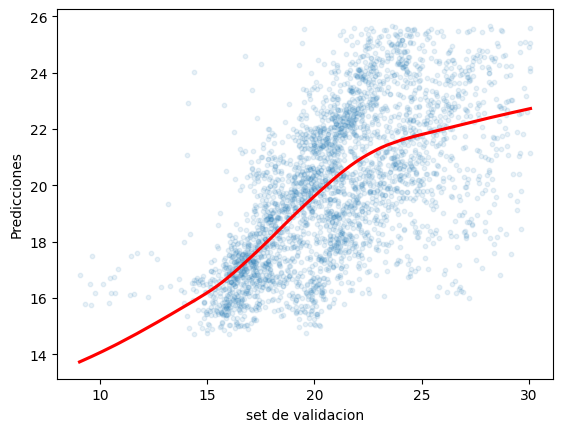

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mask_x = y_test <= np.percentile(y_test, 90)
mask_y = y_pred <= np.percentile(y_pred, 90)

mask = (mask_x) & (mask_y)
y_test_masked = y_test[mask]
y_pred_masked = y_pred[mask]

sns.regplot(x=y_test_masked, y=y_pred_masked, lowess=True,
            scatter_kws={'s':10, 'alpha':0.1}, line_kws={'color':'red'})

plt.xlabel('set de validacion')
plt.ylabel('Predicciones')
plt.show()

#### Independencia de los errores

In [ ]:
from statsmodels.stats.stattools import durbin_watson

residuos = results.resid
durbin_watson(residuos)

1.4357898218546645

Durbin-Watson: Es un test que se usa para detectar autocorrelación en los residuos de un análisis de regresión. Los valores pueden variar de 0 a 4. Un valor de 2 indica que no hay autocorrelación en la muestra. Valores por debajo de 2 sugieren autocorrelación positiva, mientras que los valores por encima de 2 indican autocorrelación negativa. La autocorrelación en los residuos viola una de las suposiciones básicas de la regresión lineal, que es que los errores son independientes, y puede llevar a estimaciones de coeficientes sesgadas

#### Normalidad

In [ ]:
from scipy import stats

# Shapiro y normaltest: H0 => Normalidad
stats.normaltest(residuos), stats.shapiro(residuos)

(NormaltestResult(statistic=3977.382014743933, pvalue=0.0),
 ShapiroResult(statistic=0.7098268270492554, pvalue=0.0))

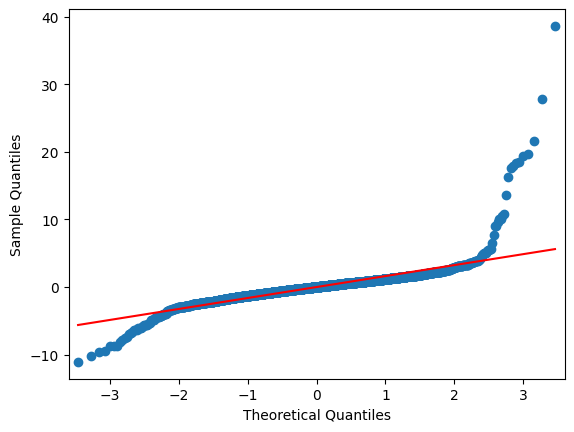

In [ ]:
from statsmodels.api import qqplot

qqplot(residuos, line='r')
plt.show()

#### Multicolinealidad

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols = X_test.columns
vif = [variance_inflation_factor(X_test.values, i) for i in range(len(X_test.columns))]

pd.DataFrame(zip(cols, vif), columns=['feature','VIF']).set_index('feature')

,VIF
feature,
const,2.376024
strikes_spread,1.231413
calls_contracts_traded,1.841670
puts_contracts_traded,2.468592
calls_open_interest,7.106914
puts_open_interest,8.799834
expirations_number,7.322853
contracts_number,5.651445
hv_20,4.612291


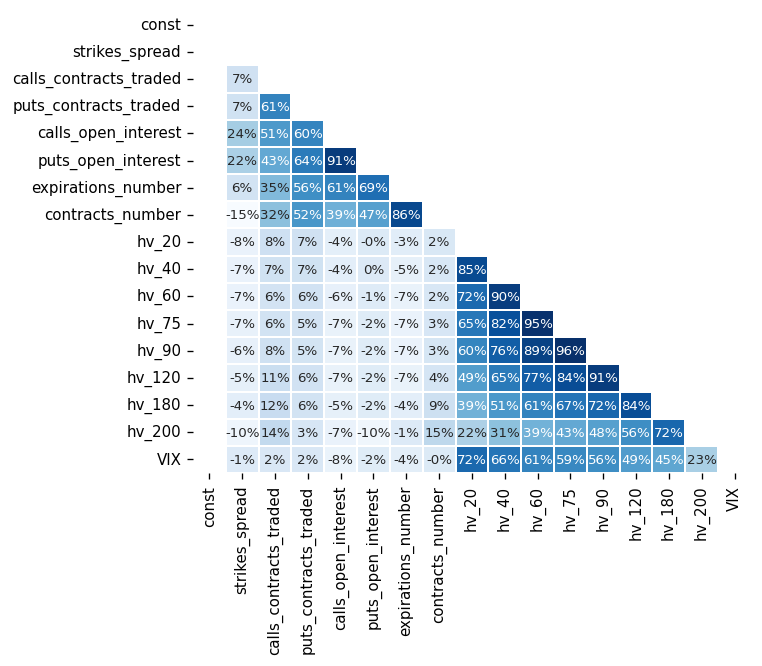

In [ ]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 120
plt.figure(figsize=(6, 5))

corr = X_test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt='.0%', cmap='Blues',
            linewidths=1, annot_kws={"size": 8}, cbar=False)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

#### Homocedasticidad

<Axes: >

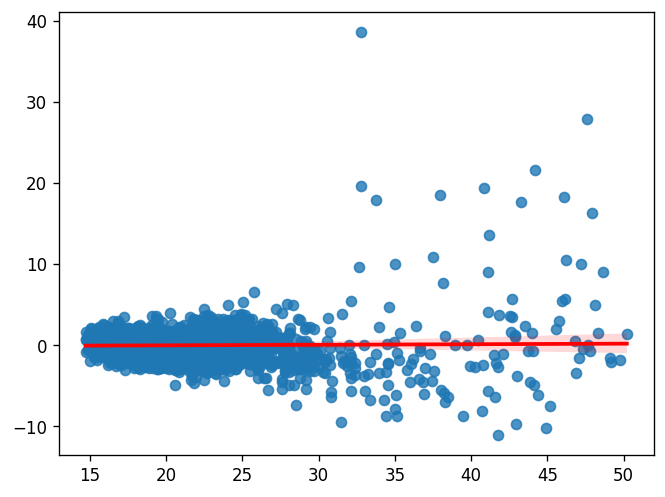

In [ ]:
import seaborn as sns

min_length = min(len(y_pred), len(residuos))
sns.regplot(x=y_pred, y=residuos[:min_length], line_kws={'color':'red'})

In [ ]:
from statsmodels.stats.diagnostic import het_white

# H0 => la varianza de los residuos es independiente (homocedasticidad)
p_val_homocedasticidad = het_white(residuos, X)
p_val_homocedasticidad[-2:]  # F estadistico y el P Valor

(6.45488043578732, 8.553974523081997e-104)

## Con  redes neuronales

### Implementacion con Keras (tensorflow)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tqdm import tqdm
import sys
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, input_dim=len(feature_cols), activation='sigmoid'))
model.add(Dropout(0.03))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=Adam())

n_epochs = 200
history = []
with tqdm(total=n_epochs, file=sys.stdout) as pbar:
    for i in range(n_epochs):
        pbar.update()
        history_epoch = model.fit(X.iloc[:,1:], y, epochs=1, batch_size=256, validation_split=0.2, verbose=0)
        history.append(history_epoch.history)
        pbar.set_postfix({'loss': history_epoch.history['loss'][0], 'val_loss': "{:.3f}".format(history_epoch.history['val_loss'][0])})

test_loss = model.evaluate(X_test.iloc[:,1:], y_test)
print('Test loss:', test_loss)

predictions = model.predict(X_test.iloc[:,1:])
mae = mean_absolute_error(y_test, predictions)
print(f'Test mean{y_test.mean():.2f} +/- {mae:.2f}')

117/117 [==============================] - 0s 2ms/step - loss: 36.0992
Test loss: 36.099220275878906
117/117 [==============================] - 0s 1ms/step
Test mean23.04 +/- 3.22


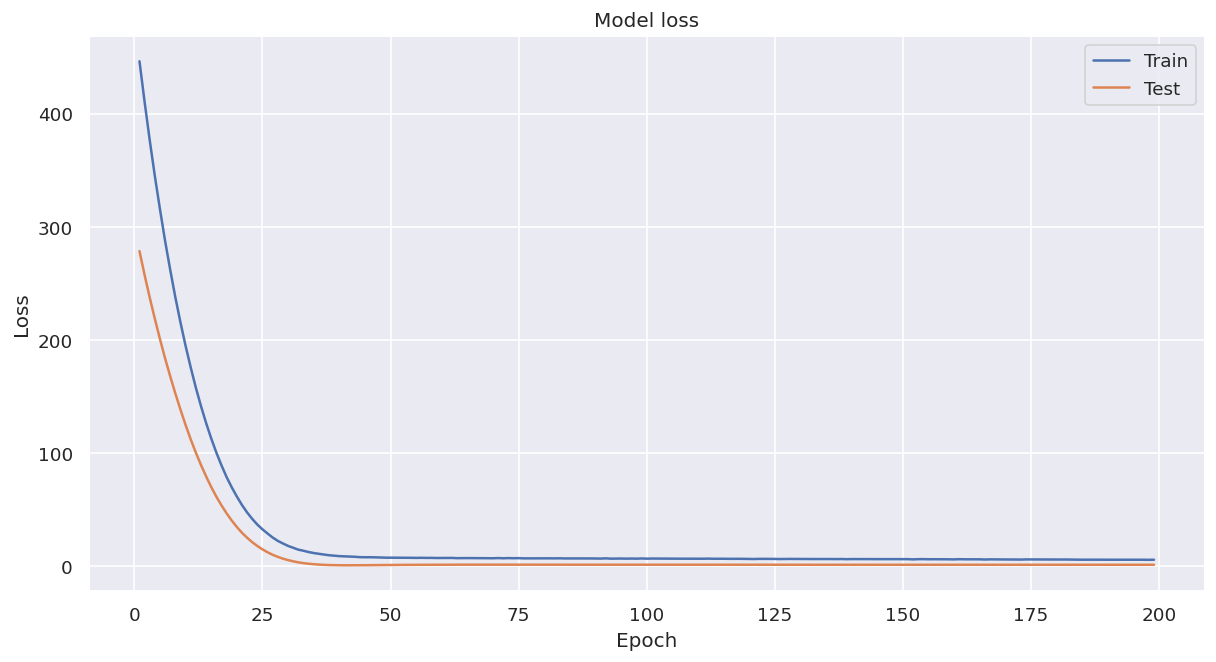

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = [{'loss': item['loss'][0], 'val_loss': item['val_loss'][0]} for item in history]
history_df = pd.DataFrame(history)
sns.set()
plt.figure(figsize=(12, 6))
plt.plot(history_df.iloc[1:]['loss'])
plt.plot(history_df.iloc[1:]['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Implementacion con pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.03)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# hay que convertir la data a PyTorch tensors
X_tensor = torch.tensor(X.iloc[:, 1:].values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(len(feature_cols)).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

n_epochs = 200
history = {'loss': [], 'val_loss': []}
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses = []
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    history['loss'].append(torch.mean(torch.tensor(train_losses)).item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_losses.append(loss.item())
    history['val_loss'].append(torch.mean(torch.tensor(val_losses)).item())

100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


In [ ]:
# Hacemos la evaluaicon

X_test_tensor = torch.tensor(X_test.iloc[:, 1:].values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256)

model.eval()
test_losses = []
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        loss = criterion(outputs, labels.unsqueeze(1))
        test_losses.append(loss.item())

test_loss = torch.mean(torch.tensor(test_losses)).item()
print('Test loss:', test_loss)

mae = mean_absolute_error(y_test, predictions)
print(f'Test mean {y_test.mean():.2f} +/- {mae:.2f}')

Test loss: 34.786293029785156
Test mean 23.04 +/- 3.17


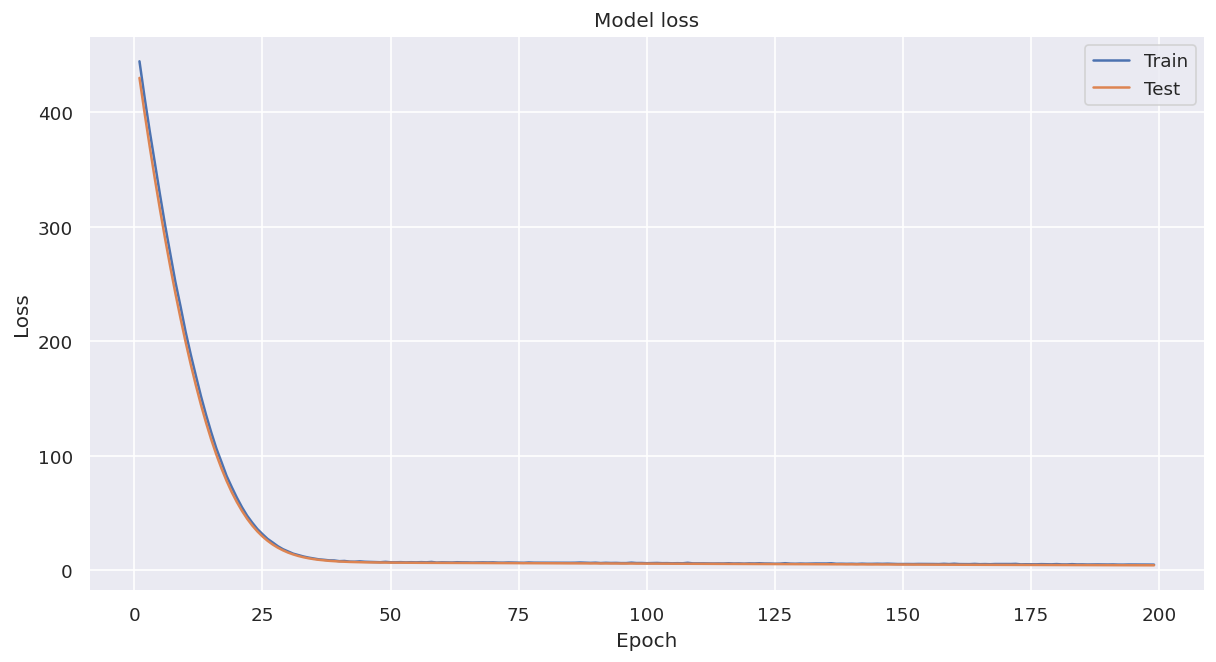

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history_df = pd.DataFrame(history)
sns.set()
plt.figure(figsize=(12, 6))
plt.plot(history_df.iloc[1:]['loss'])
plt.plot(history_df.iloc[1:]['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

feature_cols = ['strikes_spread', 'calls_contracts_traded', 'puts_contracts_traded', 'calls_open_interest',
                'puts_open_interest', 'expirations_number', 'contracts_number', 'hv_20', 'hv_40',
                'hv_60', 'hv_75', 'hv_90', 'hv_120', 'hv_180', 'hv_200', 'VIX']

model = Sequential()
model.add(Dense(128, input_dim=len(feature_cols), activation='sigmoid', kernel_regularizer=regularizers.l1(0.00003) ))
model.add(Dropout(0.05))
model.add(Dense(16, activation='sigmoid', ))
model.add(Dense(8, activation='sigmoid', ))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=Adam())

# La paciencia es la cantidad de epocas sin mejora para cortar
early_stop = EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 300

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:  # Imprime los logs cada 10 épocas
            print(f"Epoch {epoch}, MSE {logs['loss']:.2f}, Test MSE {logs['val_loss']:.2f}")

# A mas valor de batch size menos tarda por epoch pero requiere mas memoria
history = model.fit(X.iloc[:,1:], y, epochs=EPOCHS, batch_size=128,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, CustomCallback()])

test_loss = model.evaluate(X_test.iloc[:,1:], y_test, verbose=0)

print('Test loss:', test_loss)
predictions = model.predict(X_test.iloc[:,1:])
mae = mean_absolute_error(y_test, predictions)
print(f'Test mean: {y_test.mean():.2f} +/- {mae:.2f}')

Epoch 0, MSE 526.62, Test MSE 333.35
Epoch 10, MSE 404.86, Test MSE 243.36
Epoch 20, MSE 344.37, Test MSE 195.96
Epoch 30, MSE 296.21, Test MSE 158.79
Epoch 40, MSE 254.79, Test MSE 127.60
Epoch 50, MSE 218.65, Test MSE 101.16
Epoch 60, MSE 187.07, Test MSE 78.84
Epoch 70, MSE 159.57, Test MSE 60.19
Epoch 80, MSE 135.76, Test MSE 44.83
Epoch 90, MSE 115.26, Test MSE 32.43
Epoch 100, MSE 97.81, Test MSE 22.68
Epoch 110, MSE 83.11, Test MSE 15.30
Epoch 120, MSE 70.89, Test MSE 9.99
Epoch 130, MSE 60.89, Test MSE 6.50
Epoch 140, MSE 52.87, Test MSE 4.56
Epoch 150, MSE 46.60, Test MSE 3.89
Epoch 160, MSE 41.83, Test MSE 4.23
Epoch 170, MSE 38.31, Test MSE 5.30
Epoch 180, MSE 35.79, Test MSE 6.89
Test loss: 60.009910583496094
117/117 [==============================] - 0s 2ms/step
Test mean: 23.04 +/- 4.68


In [ ]:
#!pip install pydot
#!pip install graphviz

## Con Arboles

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X.iloc[:,1:], y)
print('R^2 en datos de entrenamiento: ', tree.score(X.iloc[:,1:], y))
y_pred = tree.predict(X_test.iloc[:,1:])

R^2 en datos de entrenamiento:  0.8614191159021585


In [ ]:
y_pred.mean()

21.123438097202435

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprime las métricas
print('MAE:', mae)
print('MSE:', mse)
print('R^2:', r2)

MAE: 3.573322137193216
MSE: 39.909925816680676
R^2: 0.21342253280863122


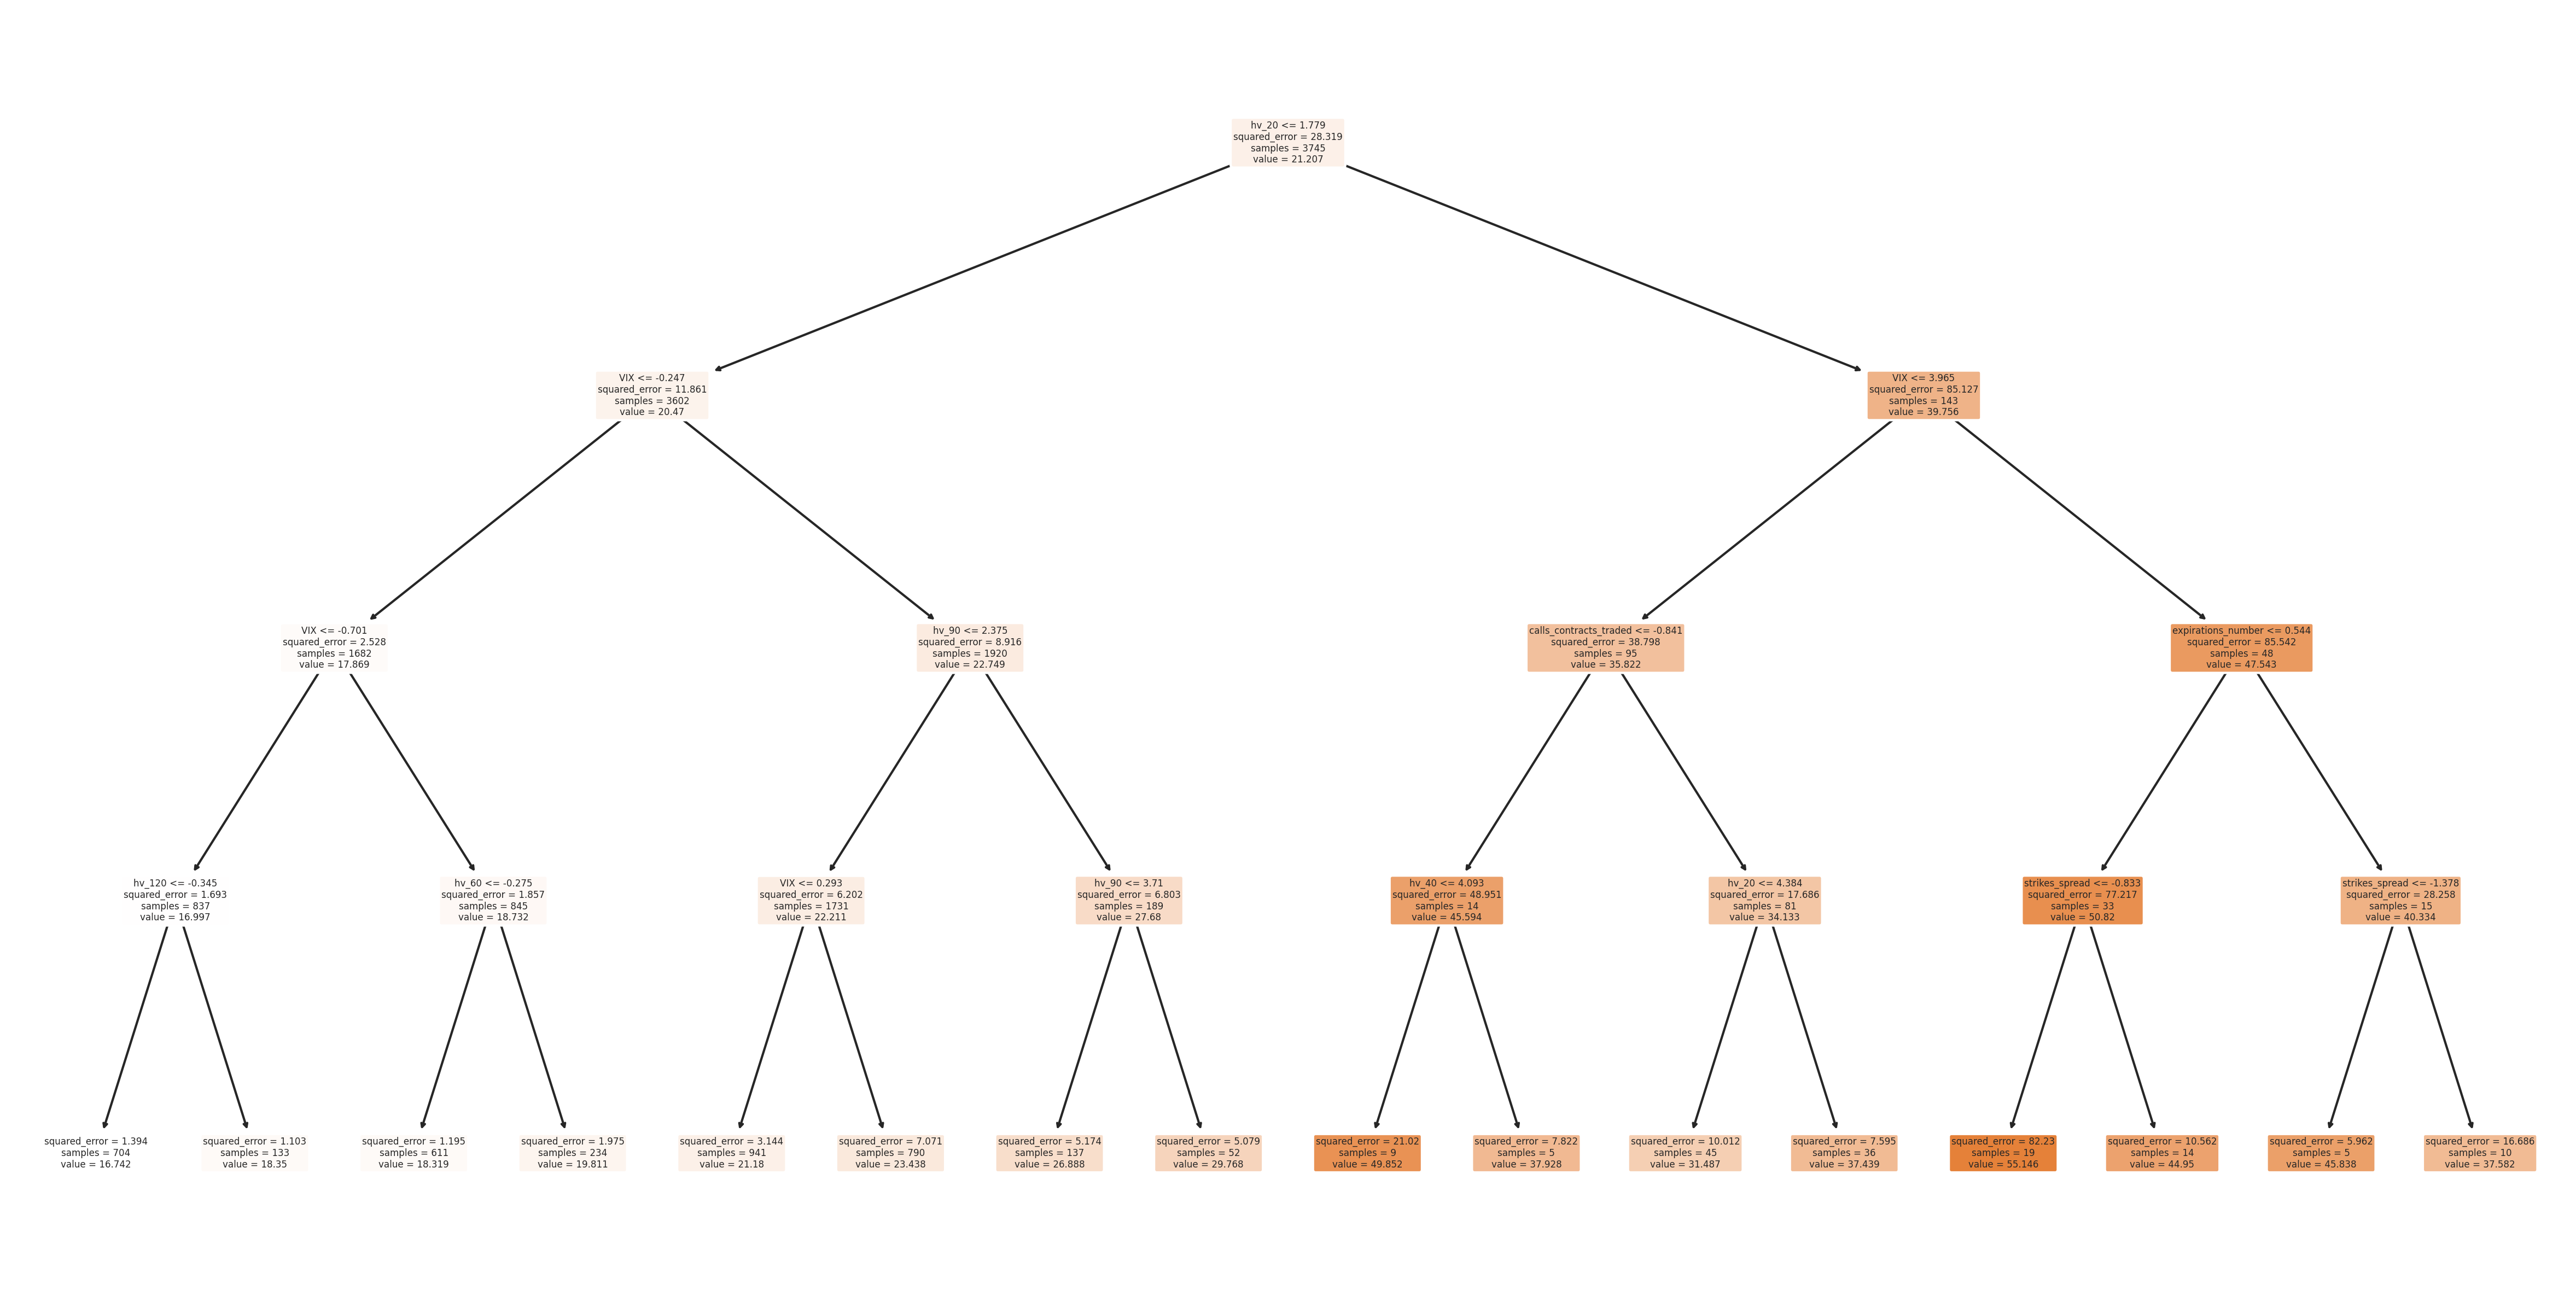

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10), dpi=300)  # Establece el tamaño de la figura
plot_tree(tree, filled=True, rounded=True, feature_names=feature_cols)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=0)
rf.fit(X.iloc[:,1:], y)

print('R^2 en datos de entrenamiento: ', rf.score(X.iloc[:,1:], y))
y_pred = rf.predict(X_test.iloc[:,1:])

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprime las métricas
print('MAE:', mae)
print('MSE:', mse)
print('R^2:', r2)

R^2 en datos de entrenamiento:  0.8931142827612693
MAE: 3.473527251478836
MSE: 37.64573494088438
R^2: 0.2580470588601752


# Clasificaciones

## Arboles de Decision

El algoritmo CART (Classification and Regression Trees) sirve para construir árboles de decisión.
Se puede utilizar tanto para problemas de clasificación como de regresión.

**Paso 1: Elegir la mejor división**

Para cada característica en el conjunto de datos, el algoritmo CART evalúa todas las divisiones posibles. Para cada división, se calcula la impureza de Gini (para problemas de clasificación) o la varianza (para problemas de regresión) de los dos subconjuntos resultantes.
<br>El objetivo es minimizar la impureza o la varianza.


\begin{equation}
  G_i = 1 - \sum_{k=1}^n p_{i,k}^2
\end{equation}

donde $p_{i,k}$ es el ratio de instancias de la clase $k$ en el nodo $i^{th}$ y $n$ es el número de clases.

La función de pérdida para la clasificación con el algoritmo CART se define de la siguiente manera:

\begin{equation}
  J(k, t_k) = \frac{m_{\textrm{left}}}{m} G_{\textrm{left}} + \frac{m_{\textrm{right}}}{m} G_{\textrm{right}}
\end{equation}

<br>
Para problemas de regresión, la varianza se calcula como:

$$
Var(D) = \frac{1}{|D|} \sum_{i \in D} (y_{i} - \bar{y})^{2}
$$

donde $|D|$ es el número de observaciones en $D$, $y_{i}$ es la etiqueta de la observación $i$, y $\bar{y}$ es la media de las etiquetas en $D$

**Paso 2: Dividir el conjunto de datos**

Una vez que se ha elegido la mejor división, el conjunto de datos se divide en dos subconjuntos, uno para cada resultado de la división.

**Paso 3: Repetir los pasos 1 y 2**

Los pasos 1 y 2 se repiten para cada uno de los subconjuntos resultantes. Este proceso se repite hasta que se cumpla alguna condición de parada, como alcanzar una profundidad máxima del árbol o un número mínimo de observaciones por hoja.

**Predicciones**

Al terminar de construirse el arbol, cada hoja del árbol representa una predicción. Para problemas de clasificación, la predicción es la clase más común en el subconjunto de datos correspondiente a esa hoja, y la probabilidad de acierto de la prediccion (no necesariamente cierta) es la cantidad de la clase mas comun de la hoja sobre el total de muestras de la misma.

Para problemas de regresión, la predicción es la media de las etiquetas en el subconjunto de datos correspondiente a esa hoja.
"""


__Ejemplos de Gini__

$$
p_{\text{{sube}}} = \frac{{50}}{{100}} = 0.5
\quad
p_{\text{{baja}}} = \frac{{50}}{{100}} = 0.5
$$
$$Gini = 1 - \sum_{{k=1}}^{K} p_{k}^{2} = 1 - \left( p_{\text{{sube}}}^{2} + p_{\text{{baja}}}^{2} \right) = 1 - \left(0.5^{2} + 0.5^{2}\right) = 0.5
$$

$$
p_{\text{{sube}}} = \frac{{20}}{{50}} = 0.4
\quad
p_{\text{{baja}}} = \frac{{30}}{{50}} = 0.6
$$
$$Gini = 1 - \sum_{{k=1}}^{K} p_{k}^{2} = 1 - \left( p_{\text{{sube}}}^{2} + p_{\text{{baja}}}^{2} \right) = 1 - \left(0.4^{2} + 0.6^{2}\right) = 0.48
$$

Debido a la naturaleza del algoritmo, los árboles de decisión son capaces de adaptarse perfectamente a cualquier dataset, resultando en *overfitting*. Esto se debe a que siempre podemos ir añadiendo nuevas condiciones de decisión hasta llegar a separar cada instancia por separado. Para evitar esto, tenemos varias alternativas:

1. Limitar la profundidad del árbol.
2. Restringir el número mínimo de muestras necesarias para crear una nueva división.
3. Definir el número mínimo de muestras que un nodo terminal debe tener.
4. Definir el número máximo de nodos terminales.
5. Definir el número máximo de características evaluadas para dividir un nodo.

Otra opción es la conocida como *pruning*, que consiste en entrenar un árbol de decisión sin ningún tipo de restricción y luego eliminar todos aquellos nodos innecesarios

In [ ]:
import numpy as np

Xc = X.iloc[:,1:]
Xc_test = data_test[feature_cols]
Xc_test = pd.DataFrame(scaler.transform(Xc_test), columns=feature_cols, index=data_test.index)

# Vamos a buscar predecir cuando la IV_ATM es mas de 25% mas alta que la HV 20 ruedas
yc = np.where(y>data_train.hv_20*1.25, 1, 0)
yc_test = np.where(y_test>data_test.hv_20*1.25, 1, 0)

In [ ]:
yc.mean(), yc_test.mean()

(0.5511348464619492, 0.5940939597315437)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', tree_clf.score(Xc, yc))
y_pred_clf = tree_clf.predict(Xc_test)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_clf))

Precisión en datos de entrenamiento:  0.9020026702269693
Precisión en datos de prueba:  0.8271140939597316


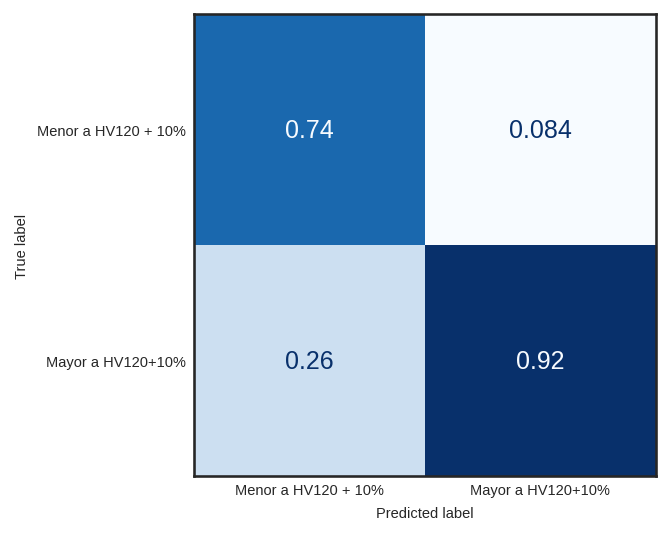

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)  # Configura el tamaño de la figura y los dpi
disp = ConfusionMatrixDisplay.from_estimator(tree_clf, Xc_test, yc_test, normalize='pred', ax=ax,
                                             display_labels=['Menor a HV120 + 10%','Mayor a HV120+10%'],
                                             cmap='Blues', colorbar=False)

disp.ax_.xaxis.set_tick_params(labelsize=7)
disp.ax_.yaxis.set_tick_params(labelsize=7)
disp.ax_.set_xlabel('Predicted label', fontsize=7)
disp.ax_.set_ylabel('True label', fontsize=7)

for text in disp.text_:
    for t in text:
        t.set_fontsize(12)


m = disp.confusion_matrix

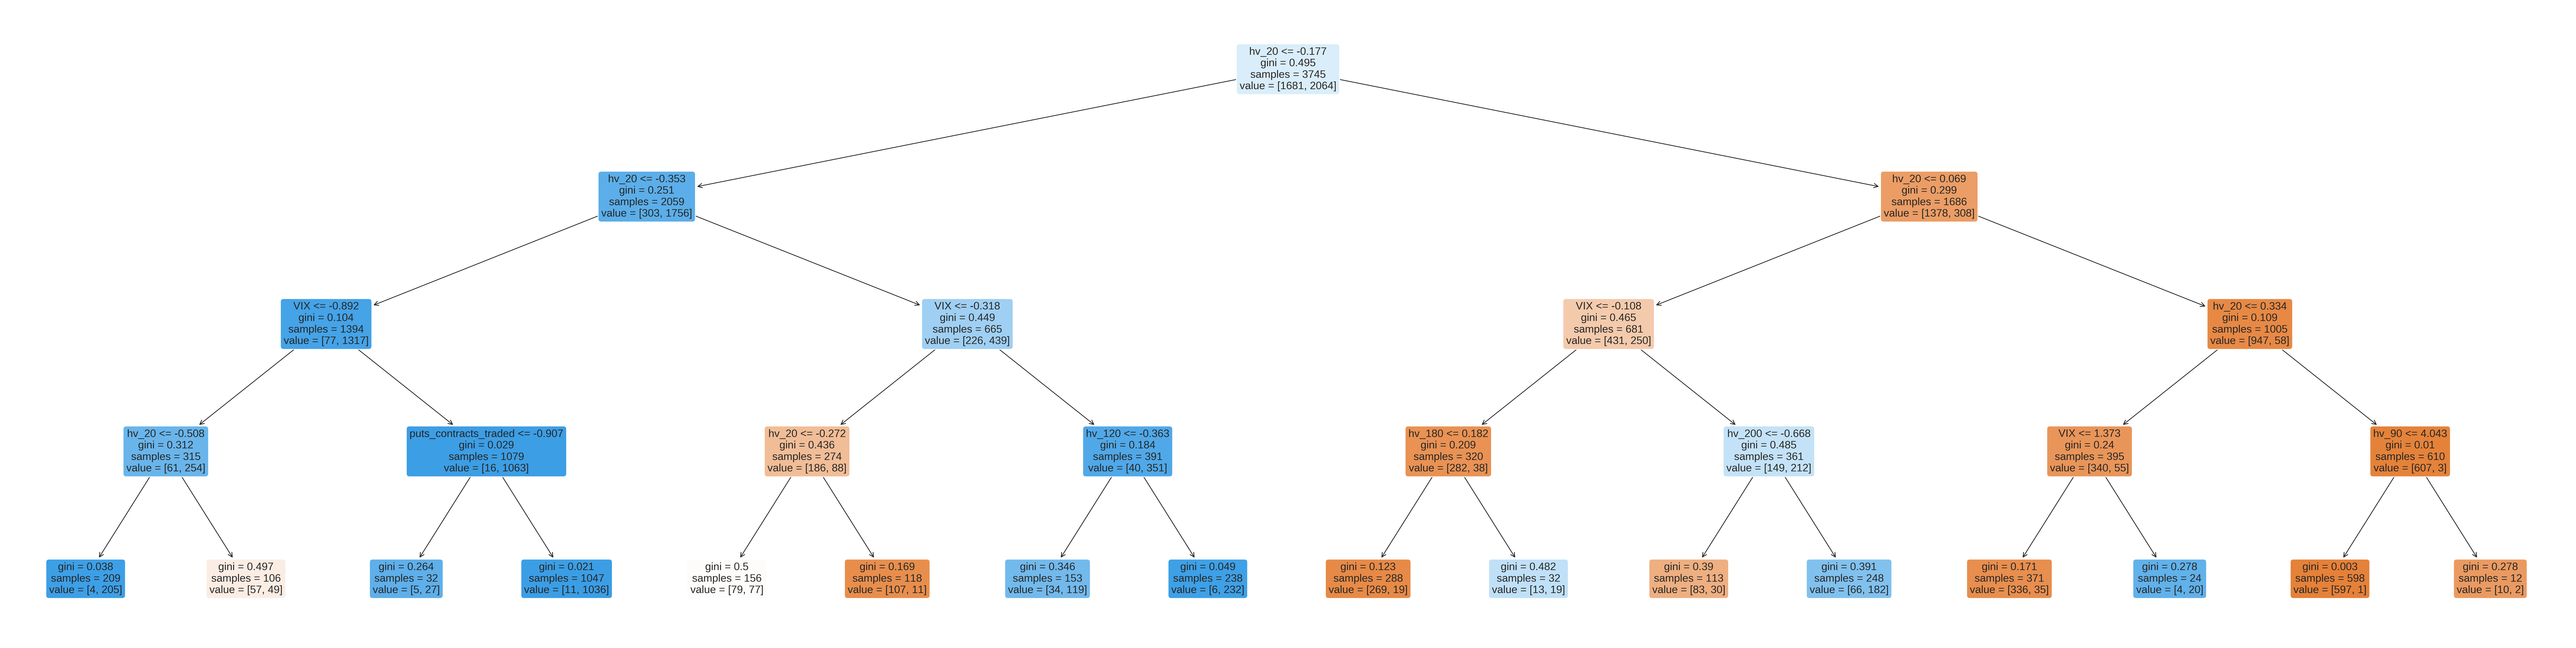

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(60,15), dpi=300)  # Establece el tamaño de la figura
plot_tree(tree_clf, filled=True, rounded=True, feature_names=feature_cols)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(yc_test, y_pred_clf)

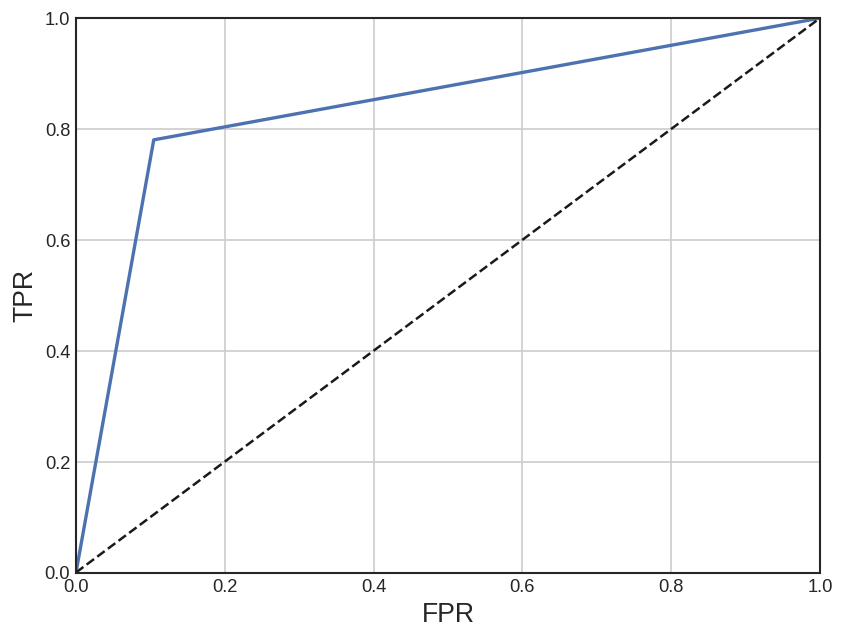

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## Regresion Logistica


$$
p(X) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 X\right)}}
$$

donde:

- $ p(X) $ es la probabilidad de que la observación $ X $ pertenezca a la clase positiva
- $ \beta_0 $ y $ \beta_1 $ son los parámetros del modelo de regresion
- $ X $ son las características de entrada
- $ e $ es la base del logaritmo natural

__Supuestos__

- No hay multicolinealidad
- Independencia de errores (no-autocorrelacion)
- No pasa naranja con:
    - Linealidad (ya que la variable dependiente va a ser categórica)
    - Normalidad de los residuos
    - Homocedasticidad

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(Xc, yc)

# Evaluar el modelo
print('Precisión en datos de entrenamiento: ', log_reg.score(Xc, yc))
y_pred_log_reg = log_reg.predict(Xc_test)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_log_reg))

Precisión en datos de entrenamiento:  0.9188251001335114
Precisión en datos de prueba:  0.832751677852349


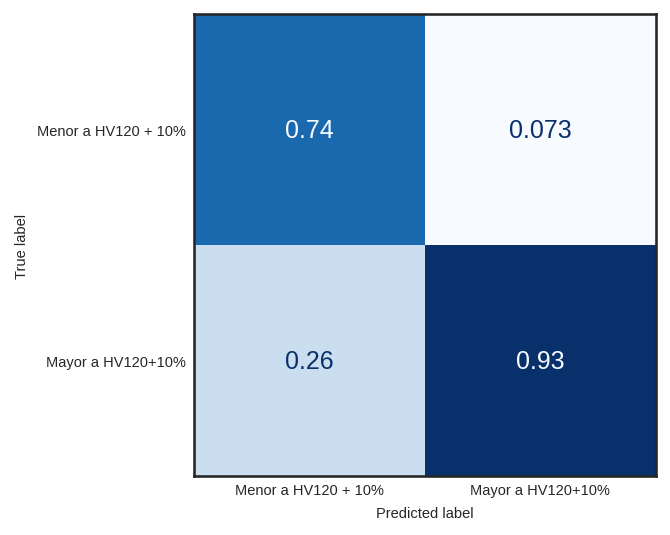

In [ ]:
y_pred_log_reg = log_reg.predict(Xc_test)
cm = confusion_matrix(yc_test, y_pred_log_reg, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Menor a HV120 + 10%', 'Mayor a HV120+10%'])

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
disp.ax_.xaxis.set_tick_params(labelsize=7)
disp.ax_.yaxis.set_tick_params(labelsize=7)
disp.ax_.set_xlabel('Predicted label', fontsize=7)
disp.ax_.set_ylabel('True label', fontsize=7)
for text in disp.text_:
    for t in text:
        t.set_fontsize(12)

plt.show()

#### Hyperparametros

__penalty__: Tipo de regularización que se aplica al modelo

    - Los valores posibles son 'l1', 'l2', 'elasticnet', y 'none'.
    - La regularización puede ayudar a prevenir el sobreajuste.

__C__: Es el inverso de la fuerza de regularización

    - Valores más pequeños especifican una regularización más fuerte

__fit_intercept__: Especifica si se debe agregar una intersección (bias) al modelo (True/False)

    - Si los datos ya están centrados no hace falta

__class_weight__: Indica si se le da más peso a una clase o no

__solver__: Es el algoritmo a utilizar para la optimización
    - Las opciones son 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'

__max_iter__: El número máximo de iteraciones para que los solvers converjan

La idea ahora es preguntarse cual de todas las posibles combinaciones de parametros me puede dar un mejor resultado. Eventualmente podriamos probar y probar, pero la idea es buscar un procedimiento lo mas estandarizado posible que tenga en cuenta todos los hyperparametros al mismo tiempo que busque una solucion robusta mediante cross-validation

### Regresion Logistica Multinomial - SOFTMAX

SOFTMAX

$$ \large
P(Y = k | X) = \frac{e^{X \cdot \beta_k}}{\sum_{j=1}^{K} e^{X \cdot \beta_j}}
$$

Donde:

- $K$ es el número total de categorías
- $X$ son las características de entrada
- $\beta_k$ son los parámetros del modelo para la categoría $k$
- $e^{X \cdot \beta_k}$ es el exponencial de la puntuación bruta para la categoría $k$


Solo dejaba esto por aca porque en adelante en redes neuronales lo van a ver muy muy seguido esta arquitectura en capas de salida

#### Validacion Cruzada con GridSearch

Dado un conjunto de hiperparámetros
$$\large \Theta = \{\theta_1, \theta_2, ..., \theta_n\},$$
Cada uno de los cuales puede tomar un conjunto de valores
$$ \large V = \{v_1, v_2, ..., v_m\},$$
Buscamos la combinación de hiperparámetros que minimiza (o maximiza) una función de pérdida (o métrica de rendimiento) $L$

Para cada combinación $\theta$ de hiperparámetros en el espacio de búsqueda de la cuadrícula
$\Theta \times V,$ entrenamos un modelo $M$ y evaluamos su rendimiento utilizando la función de pérdida $L$

El resultado de la búsqueda en cuadrícula es la combinación de hiperparámetros $\theta^*$ que minimiza (o maximiza) $L:$

$$ \large \theta^* = \arg \min_{\theta \in \Theta \times V} L(M(\theta))$$

En el caso de la validación cruzada, la función de pérdida se calcula como el promedio de la función de pérdida en cada batch

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.005, 0.01, 0.1, 0.2, 0.5, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(Xc, yc)

best_model = grid_search.best_estimator_

CPU times: user 20.1 s, sys: 8.7 s, total: 28.8 s
Wall time: 20.1 s


In [ ]:
best_model

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='saga')

In [ ]:
log_reg = LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='saga')
log_reg.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', log_reg.score(Xc, yc))
y_pred_log_reg = log_reg.predict(Xc_test)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_log_reg))

Precisión en datos de entrenamiento:  0.9190921228304406
Precisión en datos de prueba:  0.8354362416107383


## Naive Bayes

$$
P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}
$$

Donde:

- $P(y|X)$ es la probabilidad posterior de la clase "y" (target) dado el predictor X
- $P(y)$ es la probabilidad a priori de la clase o target (mas alla de X)
- $P(X|y)$ es la probabilidad de X dada o sabida la clase
- $P(X)$ es la probabilidad a priori del predictor o feature X

Lo mismo para "k" predictores o features

$$
P(y|X_1,X_2,...,X_k) = \frac{P(X_1,X_2,...,X_k|y) \cdot P(y)}{P(X_1,X_2,...,X_k)}
$$


> WARNING: Para NB los features deben ser independientes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_clf = GaussianNB()
nb_clf.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', nb_clf.score(Xc, yc))
y_pred_nb = nb_clf.predict(Xc_test)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_nb))

Precisión en datos de entrenamiento:  0.7012016021361815
Precisión en datos de prueba:  0.7369127516778523


## SVM

La función del kernel RBF se define como:

$$ \large
K(x, x') = e^{-\gamma||x - x'||^2}
$$

Donde:

- $K(x, x')$ es el kernel RBF entre los vectores de características $x$ y $x'$
- $\gamma$ es el parámetro del kernel RBF, que determina cuánto influyen los vectores lejanos en el cálculo del kernel
- $||x - x'||^2$ es la distancia euclídea al cuadrado entre los vectores de características $x$ y $x'$

En el caso de una SVM con un kernel RBF, el modelo se puede expresar como:

$$ \large
f(x) = \sum_{i=1}^{N} \alpha_i y_i e^{-\gamma||x - x_i||^2} + b
$$

Donde:

- $N$ es el número de vectores de soporte
- $\alpha_i$ son los multiplicadores de Lagrange, determinados durante el entrenamiento de la SVM
- $y_i$ son las etiquetas de clase de los vectores de soporte
- $x_i$ son los vectores de soporte
- $b$ es el término de sesgo

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', gamma='scale')
svm_clf.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', svm_clf.score(Xc, yc))
y_pred_svm = svm_clf.predict(Xc_test)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_svm))

Precisión en datos de entrenamiento:  0.927369826435247
Precisión en datos de prueba:  0.8319463087248322


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define los valores de los parámetros a probar
param_grid = {'C': [10],
              'gamma': ['scale'],
              'kernel': ['rbf', 'linear', 'poly'],
              'degree': [2, 3, 4],
              'coef0': [0.0, 0.1, 0.5],
              'class_weight': [None, 'balanced']}

svm = SVC(kernel='rbf')

grid_search = GridSearchCV(svm, param_grid, cv=5)
# Validación cruzada de 5 batchs

grid_search.fit(Xc, yc)

print('Los mejores parámetros encontrados son:', grid_search.best_params_)
best_svm = grid_search.best_estimator_
y_pred_best_svm = best_svm.predict(Xc_test)
print('Precisión en datos de prueba con los mejores parámetros: ', accuracy_score(yc_test, y_pred_best_svm))

Los mejores parámetros encontrados son: {'C': 10, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Precisión en datos de prueba con los mejores parámetros:  0.829261744966443
CPU times: user 1min 11s, sys: 1.62 ms, total: 1min 11s
Wall time: 1min 15s


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
%%time

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', rf_clf.score(Xc, yc))
y_pred_proba = rf_clf.predict_proba(Xc_test)

y_pred_rf = np.argmax(y_pred_proba, axis=1)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_rf))

Precisión en datos de entrenamiento:  1.0
Precisión en datos de prueba:  0.8553020134228188
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.36 s


## Otros modelos de ensamble de arboles

### XGBoost

El XGBoost (eXtreme Gradient Boosting) es una implementación del algoritmo Gradient Boosting

El objetivo de XGBoost, es minimizar una función de pérdida L:

$$ \large
L(y, \hat{y}) = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

Donde:

- $L$ es la función de pérdida total
- $n$ es el número total de muestras en el conjunto de datos
- $l$ es la función de pérdida específica que se está utilizando (por ejemplo, error cuadrado medio para la regresión, entropía cruzada para la clasificación)
- $y_i$ es la etiqueta real para la muestra $i$
- $\hat{y}_i$ es la predicción para la muestra $i$
- $K$ es el número total de árboles en el modelo
- $f_k$ es el k-ésimo árbol en el modelo
- $\Omega$ es una función de regularización que controla la complejidad del modelo para prevenir el sobreajuste
- $\Omega(f_k)$ es la complejidad del k-ésimo árbol

La función de regularización $\Omega$ se define de la siguiente manera:

$$ \large
\Omega(f) = \gamma T + \frac{1}{2} \lambda ||w||^2
$$

Donde:

- $T$ es el número de nodos hoja en el árbol
- $\gamma$ es un parámetro que controla la penalización por el número de nodos hoja
- $w$ es el vector de los valores de los nodos hoja en el árbol
- $\lambda$ es un parámetro que controla la penalización por los valores de los nodos hoja

XGBoost agrega nuevos árboles al modelo para minimizar la función de pérdida utilizando el método del descenso del gradiente

Además, XGBoost incluye varias técnicas para mejorar el rendimiento y la eficiencia del algoritmo, como el manejo inteligente de valores faltantes, la paralelización de la construcción de árboles, y la capacidad para manejar matrices dispersas, entre otras.


In [ ]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
%%time

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=1000)
xgb_clf.fit(Xc, yc)

y_pred_proba = xgb_clf.predict_proba(Xc_test)
y_pred_xgb = np.argmax(y_pred_proba, axis=1)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_xgb))

Precisión en datos de prueba:  0.8480536912751678
CPU times: user 11.2 s, sys: 31.4 ms, total: 11.2 s
Wall time: 8.45 s


### ADABoost

AdaBoost (Adaptive Boosting) es un algoritmo de ensamble que combina varios modelos de aprendizaje débil para crear un modelo de aprendizaje fuerte. Crea los modelos de aprendizaje débil (por ejemplo arboles de decision) en una secuencia donde cada modelo trata de corregir los errores del modelo anterior

Dado un conjunto de datos de entrenamiento $\{(x_1, y_1), ..., (x_n, y_n)\}$ donde $x_i$ es el vector de características de la i-ésima instancia y $y_i$ es la etiqueta de clase correspondiente, AdaBoost sigue los siguientes pasos:

1. Inicialmente, todas las instancias de entrenamiento son asignadas a un peso $w_i$, que es igual para todas las instancias
2. Para cada iteración $t$ en el rango $(1, ..., T)$, se realiza lo siguiente:

    a. Se entrena un clasificador débil $h_t(x)$ en el conjunto de entrenamiento, teniendo en cuenta los pesos $w_i$ de cada instancia.
    <br>b. Se calcula el error del clasificador débil, definido como la suma de los pesos de las instancias que fueron clasificadas incorrectamente:

    $$ \large
    \epsilon_t = \frac{\sum_{i=1}^{n} w_i I(y_i \neq h_t(x_i))}{\sum_{i=1}^{n} w_i}
    $$

    c. Se calcula el coeficiente $\alpha_t$ para el clasificador débil, el cual es proporcional al logaritmo de la inversa del error:

    $$  \large
    \alpha_t = \frac{1}{2} \log \left( \frac{1 - \epsilon_t}{\epsilon_t} \right)
    $$

    d. Se actualizan los pesos de las instancias:

    $$  \large
    w_i = w_i \cdot \exp \left[ \alpha_t I(y_i \neq h_t(x_i)) \right]
    $$

3. Finalmente, la salida del modelo AdaBoost es una combinación lineal de los clasificadores débiles, donde cada clasificador está ponderado por su coeficiente $\alpha_t$:

$$  \large
H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right)
$$

Para una clasificacion multiclase se debe modificar la funcion final H(x) por:
$$ H(x) = \text{argmax}_{k \in \{1,2,\ldots,K\}} \left( \sum_{t=1}^{T} \alpha_t I(h_t(x) = k) \right)
 $$
 Donde I(.) es la funcion que determina las clases binarias o Verdaero/Falso

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [ ]:
%%time
ab_clf = AdaBoostClassifier(n_estimators=1000)
ab_clf.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', ab_clf.score(Xc, yc))
y_pred_proba = ab_clf.predict_proba(Xc_test)

# Usar np.argmax para obtener la clase con la mayor probabilidad para cada instancia
y_pred_ab = np.argmax(y_pred_proba, axis=1)

print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_ab))

Precisión en datos de entrenamiento:  0.998931909212283
Precisión en datos de prueba:  0.7806711409395973
CPU times: user 11.1 s, sys: 11.9 ms, total: 11.1 s
Wall time: 11.2 s


### Stacking

El método de ensamble de Stacking (Stacked Generalization) se puede dividir en dos partes:

**Parte 1: Entrenamiento de los modelos base**

Para un conjunto de datos de entrenamiento $(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)$, donde $x_i$ son las características y $y_i$ son las etiquetas correspondientes, entrenamos $M$ modelos base $f_1, f_2, ..., f_M$.

Cada modelo base $f_m$ produce un conjunto de predicciones $\hat{y}_1^m, \hat{y}_2^m, ..., \hat{y}_n^m$.

**Parte 2: Entrenamiento del meta-modelo**

Las predicciones de los modelos base se usan como entrada para entrenar un meta-modelo

Para cada ejemplo de entrenamiento $(x_i, y_i)$, las predicciones de los modelos base $\hat{y}_i^1, \hat{y}_i^2, ..., \hat{y}_i^M$ se combinan en un nuevo vector de características $z_i = [\hat{y}_i^1, \hat{y}_i^2, ..., \hat{y}_i^M]$

El meta-modelo se entrena en el nuevo conjunto de datos $(z_1, y_1), (z_2, y_2), ..., (z_n, y_n)$

Finalmente, para hacer una predicción para una nueva instancia, primero se pasan las características de esa instancia a través de los modelos base, luego las predicciones de los modelos base se combinan y se alimentan al meta-modelo para producir la predicción final


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=500)),
                 ('rf_2', AdaBoostClassifier(n_estimators=500))
                ]
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
clf.fit(Xc, yc)

print('Precisión en datos de entrenamiento: ', clf.score(Xc, yc))
y_pred_stacked = clf.predict(Xc_test)
print('Precisión en datos de prueba: ', accuracy_score(yc_test, y_pred_stacked))

Precisión en datos de entrenamiento:  1.0
Precisión en datos de prueba:  0.858255033557047
CPU times: user 54 s, sys: 72.2 ms, total: 54.1 s
Wall time: 54.2 s
